# Requirements
* Imports : ```numpy, librosa, PIL.Image, tensorflow, pyplot, pandas, sklearn, pathlib```     
* Predefined Functions : ```Audio(), read_csv()```    
* Path Variables : ```base_path, urban paths, jamendo paths, test paths```    

In [13]:
import os,sys

import numpy as np

import librosa
import librosa.display

from PIL import Image

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import KFold

from datetime import datetime

import pathlib
import random

#Conda attempts to use python 3.1 if 3.10 version is installed -> conda base update
#OSError: cannot load library 'sndfile.dll': error 0x7e -> move _soundfile_data from pip installation to conda installation (site_packages)

## Predefined functions 
```Audio(), read_csv()```

In [14]:
#### Used for listening to audio samples in ipynb

import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [15]:
#jamendo_tags = pd.read_csv(sorted(jamendo_metadata_path.glob('*'))[0], sep="\t")
# cannot be read in this way, need a special script given by MTG-jamendo on Github
import csv
from collections import defaultdict

CATEGORIES = ['genre', 'instrument', 'mood/theme']
TAG_HYPHEN = '---'
METADATA_DESCRIPTION = 'TSV file with such columns: TRACK_ID, ARTIST_ID, ALBUM_ID, PATH, DURATION, TAGS'

def get_id(value):
    return int(value.split('_')[1])

def get_length(values):
    return len(str(max(values)))

def read_file(tsv_file):
    tracks = {}
    tags = defaultdict(dict)

    # For statistics
    artist_ids = set()
    albums_ids = set()

    with open(tsv_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            track_id = get_id(row[0])
            tracks[track_id] = {
                'id': track_id,
                'artist_id': get_id(row[1]),
                'album_id': get_id(row[2]),
                'path': row[3],
                'duration': float(row[4]),
                'tags': row[5:],  # raw tags, not sure if will be used
            }
            tracks[track_id].update({category: set() for category in CATEGORIES})

            artist_ids.add(get_id(row[1]))
            albums_ids.add(get_id(row[2]))

            for tag_str in row[5:]:
                category, tag = tag_str.split(TAG_HYPHEN)

                if tag not in tags[category]:
                    tags[category][tag] = set()

                tags[category][tag].add(track_id)

                if category not in tracks[track_id]:
                    tracks[track_id][category] = set()

                tracks[track_id][category].update(set(tag.split(",")))

    print("Reading: {} tracks, {} albums, {} artists".format(len(tracks), len(albums_ids), len(artist_ids)))

    extra = {
        'track_id_length': get_length(tracks.keys()),
        'artist_id_length': get_length(artist_ids),
        'album_id_length': get_length(albums_ids)
    }
    return tracks, tags, extra


## Path Variables
```base_path, urban paths, jamendo paths, test paths```

In [16]:
base_path = pathlib.Path('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets') #cannot use \

#Urbansound is nested in Datasets/Urbansound8K/audio/fold**
#Urbansound is already separated into batches, which need to be preserved.
urban_metadata_path = pathlib.Path(base_path/'Urbansound8K/metadata')
urban_audio_folders_path = pathlib.Path(base_path/'Urbansound8K/audio')
urban_audio_path_list = [x for x in urban_audio_folders_path.iterdir()][1:] #remove .DS_Store

#Jamendo is nested in Datasets/MTGJamendo/audio
#Jamendo is not separated in batches, so we need to separate it into 10 batches, matching urbansound.
jamendo_metadata_path = pathlib.Path(base_path/'MTGJamendo/metadata')
jamendo_audio_path = pathlib.Path(base_path/'MTGJamendo/audio')

#for later -> add a path for any .wav file that I want to observe.
test_subjects_path = pathlib.Path("./")

# Loading and Checking audio/metadata files

## Metadata Files
* ```Checks existence```
* ```Prints .head()```

In [17]:
# Checks if .csv exists.

print(sorted(urban_metadata_path.glob("*")))
assert( pathlib.Path('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/metadata/UrbanSound8K.csv') in sorted(urban_metadata_path.glob("*")))
print(sorted(jamendo_metadata_path.glob("*")))
assert( pathlib.Path('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/MTGJamendo/metadata/raw_30s_cleantags.tsv') in sorted(jamendo_metadata_path.glob("*")))

[WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/metadata/.DS_Store'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/metadata/.gitignore'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/metadata/UrbanSound8K.csv')]
[WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/MTGJamendo/metadata/.gitignore'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/MTGJamendo/metadata/raw_30s_cleantags.tsv')]


In [18]:
urban_tags = pd.read_csv(sorted(urban_metadata_path.glob('*'))[2])
urban_tags.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [19]:
(tracks,_,_) = read_file(sorted(jamendo_metadata_path.glob('*'))[1])
jamendo_tags = pd.DataFrame.from_dict(tracks,orient='index')
jamendo_tags.head()

Reading: 55701 tracks, 11280 albums, 3573 artists


,id,artist_id,album_id,path,duration,tags,genre,instrument,mood/theme
214,214,14,31,14/214.mp3,124.6,[genre---punkrock],{punkrock},{},{}
215,215,14,31,15/215.mp3,151.4,[genre---metal],{metal},{},{}
216,216,14,31,16/216.mp3,234.9,[genre---metal],{metal},{},{}
217,217,14,31,17/217.mp3,127.9,[genre---punkrock],{punkrock},{},{}
218,218,14,31,18/218.mp3,180.7,[genre---punkrock],{punkrock},{},{}


## Audio Files
* Extract samples from paths
* Prints Music sample's waveform + audio

In [34]:
# Take a sample from both urban and jamendo;

urban_sample_path = urban_audio_path_list[random.randrange(0,len(urban_audio_path_list))]
urban_sample_path = sorted(urban_sample_path.glob('*.wav'))
urban_sample_path = urban_sample_path[random.randrange(0,len(urban_sample_path))]

jamendo_sample_path = sorted(jamendo_audio_path.glob('*.mp3'))
jamendo_sample_path = jamendo_sample_path[random.randrange(0,len(jamendo_sample_path))]

# without ffmpeg on windows, librosa cannot load .mp3 files. (NoBackendError), download manual at https://www.geeksforgeeks.org/how-to-install-ffmpeg-on-windows/ 
urban_sample,urban_sr = librosa.load(str(urban_sample_path), res_type='kaiser_fast')
jamendo_sample,jamendo_sr = librosa.load(str(jamendo_sample_path),res_type='kaiser_fast')

print(urban_sample.shape)
print(jamendo_sample.shape)

(88200,)
(3680723,)


### ```Waveform of Urbansound8K sample & MTG-Jamendo sample (in order)```

['engine_idling']
[{'easylistening', 'poprock', '60s'}]


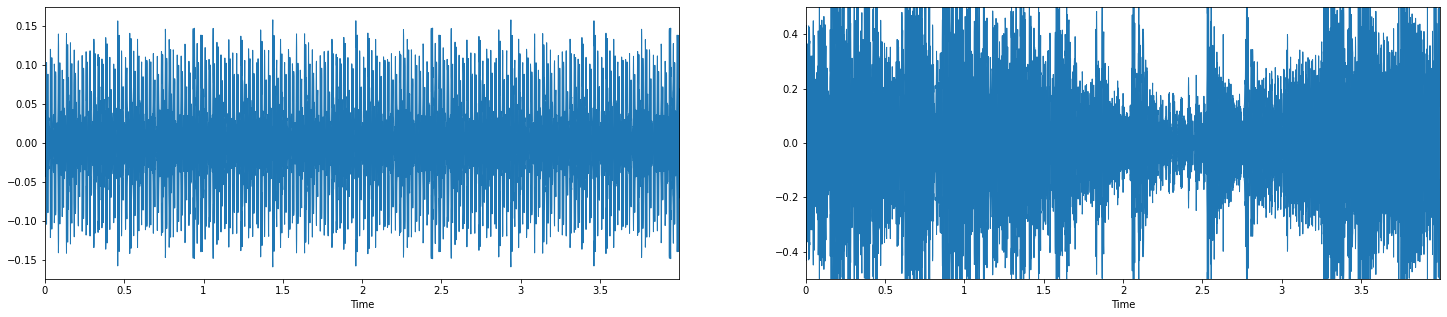

In [35]:
plt.figure(figsize=(25, 5))
temp_phase_shift_jam = 100000
temp_phase_shift_urban = 0
temp_sample_len = 88200

plt.subplot(1, 2, 1)
librosa.display.waveplot(urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban])
plt.subplot(1, 2, 2)
librosa.display.waveplot(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam])
#librosa 0.9 changes waveplot -> waveshow. so check the version of librosa in the env.

plt.ylim(-0.5, 0.5)
jamendo_id = str(jamendo_sample_path).split('\\')[-1][:-4]
urban_id = str(urban_sample_path).split('\\')[-1][:]

print(urban_tags[urban_tags['slice_file_name']==urban_id]['class'].to_numpy())
print(jamendo_tags[jamendo_tags['id']==int(jamendo_id)]['genre'].to_numpy())

### ```Noise Sample```

In [22]:
Audio(urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban],urban_sr)

### ```Music Sample```

In [23]:
Audio(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam],jamendo_sr)

# Setting Preprocessing variables
    We will make a complex array of size (513,345) (best possible resolution)
    513 = n_fft//2 + 1 => n_fft = 1024
    345 = ceil(signal_length / hop_length) => hop_length = n_fft // 4 (?) = 256 , signal_length = 88200? 

In [24]:
n_fft = 1024
hop_length = n_fft//4 #256
sr = 22050
signal_length = 88200

n_data_urban = urban_tags.shape[0]
n_data_jam = jamendo_tags.shape[0]
jam_id_list = jamendo_tags['id'].to_numpy()

# Setting Preprocessing Functions

### ```Getting Labels (To provide the model with info)```

In [25]:
def get_labels(file_path): 
    # music is 1, sound is 0
    flag_jamendo = False
    if str(file_path).find("MTGJamendo") != -1:
        flag_jamendo = True
    
    if flag_jamendo:
        label = "music"
    else:
        urban_id = file_path.parts[-1] + ".wav"
        if urban_tags[urban_tags['slice_file_name']==urban_id]['class'].to_numpy()[0] == "street_music":
            label = "music"
        else:
            label = "noise"
    return label

### ```Functions for Saving numpy arrays```

In [48]:
def save_with_npy(temp_X, save_file_path, k):
    assert(temp_X.dtype == 'float32')
    np.save(  pathlib.Path(  str(save_file_path)+"_"+str(k)+".npy"  ),temp_X,allow_pickle=True)
    return

In [49]:
def save_as_image(temp_X, save_file_path,k):
    pil_image=Image.fromarray(temp_X)
    pil_image = pil_image.convert("L")
    pil_image.save(str(save_file_path)+"_"+str(k)+".jpeg")

### ```Final Preprocessing function```

In [50]:
def split_and_sample(signal,sr,save_file_path,option):
    #split the signal
    if len(signal) < signal_length:
        return False
    else:
        temp_sliced_list = []
        temp_for_slicing = signal[:]
        while len(temp_for_slicing) >= signal_length:
            temp_sliced_list.append(temp_for_slicing[:signal_length])
            temp_for_slicing=temp_for_slicing[signal_length:]
            assert len(temp_sliced_list[-1]) == signal_length
    for k in range(len(temp_sliced_list)):
        #stft
        temp_X = librosa.stft(temp_sliced_list[k],n_fft=n_fft,hop_length=hop_length)
        final_X = librosa.power_to_db(abs(temp_X)) # edited 2022-08-29 added spectrogram makin in preprocessing step, not input pipeline
        #save the images with proper recognizable names that contain the labels
        if option==1:
            return final_X, librosa.stft(temp_sliced_list[k],n_fft=n_fft,hop_length=hop_length) #testmode
        save_with_npy(final_X, save_file_path, k)
            # The directories must preexist to save np files
        #save_as_image(temp_X, save_file_path,k)

### ```Test out if STFT works properly```

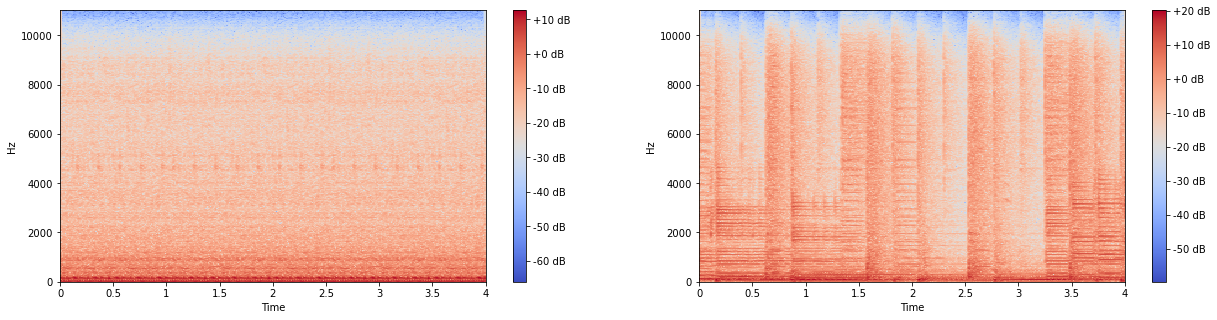

In [51]:
(processed_urban_sample, _) = split_and_sample(urban_sample,sr,"",1)
(processed_jam_sample, _) = split_and_sample(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam],sr,"",1)

plt.figure(figsize=(21, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(processed_urban_sample, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(processed_jam_sample, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

In [52]:
reconstruct_urban_sample = librosa.istft(split_and_sample(urban_sample,sr,"",1)[1],hop_length=hop_length)
reconstruct_jamendo_sample = librosa.istft(split_and_sample(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam],sr,"",1)[1],hop_length=hop_length)

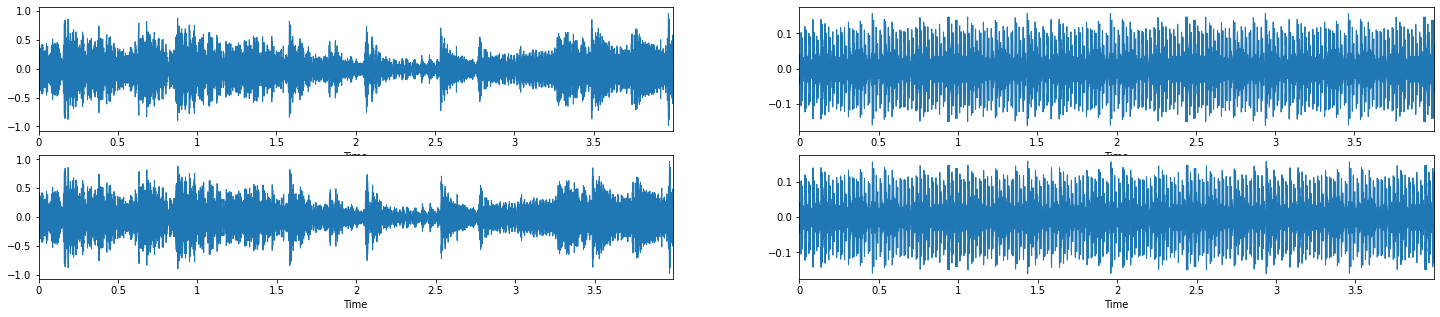

In [53]:
plt.figure(figsize=(25, 5))
plt.title('Waveform of Urbansound8K sample & MTG-Jamendo sample (in order)')
temp_phase_shift_jam = 100000
temp_phase_shift_urban = 0
temp_sample_len = 88200

plt.subplot(2, 2, 1)
librosa.display.waveplot(jamendo_sample[temp_phase_shift_jam:temp_sample_len+temp_phase_shift_jam])
plt.subplot(2, 2, 3)
librosa.display.waveplot(reconstruct_jamendo_sample)

plt.subplot(2, 2, 2)
librosa.display.waveplot(urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban])
plt.subplot(2, 2, 4)
librosa.display.waveplot(reconstruct_urban_sample[temp_phase_shift_urban:temp_sample_len+temp_phase_shift_urban])

# Preprocessing & Saving

## ```Urbansound8K```

In [55]:
#Urbansound8K
count = 0
for i in range(n_data_urban):
    temp_fold_template = pathlib.Path("fold"+str(urban_tags['fold'][i]))
    temp_filepath = pathlib.Path(urban_audio_folders_path/temp_fold_template/urban_tags['slice_file_name'][i])
    temp_time_pressure_array,sr = librosa.load(temp_filepath, res_type='kaiser_fast')
    
    save_file_path = pathlib.Path(str(base_path)+"/Urbansound8K/processed/"+str(temp_fold_template)+"/"+str(urban_tags['slice_file_name'][i])[:-4])
    temp_label = get_labels(file_path=save_file_path)
    save_file_path = pathlib.Path(str(save_file_path)+"_"+temp_label)
    refuted = split_and_sample(temp_time_pressure_array,sr,save_file_path,0)
    if refuted == False: count += 1
print(count)

1399


## ```MTG-Jamendo```

In [57]:
#MTG-Jamendo
count = 0
for i in range(n_data_jam):
    #must check whether the file exists in the dataset or not.
    temp_filepath = pathlib.Path(str(jamendo_audio_path)+'/'+str(jam_id_list[i])+".mp3")
    if temp_filepath.exists():
        temp_time_pressure_array,sr = librosa.load(temp_filepath, res_type='kaiser_fast')
        save_file_path = pathlib.Path(str(base_path)+"/MTGJamendo/processed/"+ "fold" + str(count%10 + 1) + '/' + str(jam_id_list[i]) )
        count += 1
        temp_label = get_labels(file_path=save_file_path)
        save_file_path = pathlib.Path(str(save_file_path)+"_"+temp_label)
        split_and_sample(temp_time_pressure_array,sr,save_file_path,0)
print(count)

586
